# 1. Understanding the problem

## 1.1 What affects electricity consumption per househould?

Refering to [fuel consumption summary](https://www.eia.gov/consumption/residential/data/2009/c&e/ce2.1.xlsx), the average electricity consumption is 38.6 BTU. From this table, the following consumers may tend to consume electricity more:

Feature|Category
-|-
Census Region|South
Urban and Rural|Rural
Metropolitan or else|satistical area
Climate Region|Hot-Humid
Housing Unit Type|Single-Family Detached <br> Mobile Homes
Ownership|Owned
Year of Construction|newer
Total Square Footage|larger
Number of Household Members|more
Income|more

This result make sense. Next step, look into the data codebook. 

## 1.2 Look into the variables

Refering to the [variable and response codebook](https://www.eia.gov/consumption/residential/data/2009/xls/recs2009_public_codebook.xlsx), there are 4 kinds of variables: 

1. **Continuous variables**: Response field is blank, such as `TOTSQFT` (total square footage)
2. **Imputation flags of other features**: such as ZKOWNRENT (imputation flag for KOWNRENT). 
3. **Categories considered as numbers**: such as YEARMADE (year housing unit was build), here, they will be treated as **number**. 
4. **Categories not considered as numbers**: such as REGIONC (census region), here, they will be **treated as string** with method `pandas.get_dummies`

Next step is selecting features.

# 2 Selecting features

import libraries


In [1]:
import keras
import numpy as np  
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from keras.models import Sequential 
from keras.layers import Dense,Activation
from keras.optimizers import SGD

from scipy.special import boxcox1p
from scipy.stats import norm, skew

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def ignore_warn(*args, **kwargs):
    pass

Using TensorFlow backend.


## 2.1 Continuous variable screening

Many variables actually have the same meaning, such as those contain `BTU`, `DOL`, they are redundant, as it would cause multicollinearity. So these variable should be dropped. Besides, `DesignDBT99` is dropped because there is a negative value which is against the rule. 

In [2]:
DATA_FILE_PATH = './recs2009_public.csv'
df = pd.read_csv(DATA_FILE_PATH)

LABEL_FILE_PATH = './contiNumLabel.csv'
contiNum = pd.read_table(LABEL_FILE_PATH,header=None,encoding='gb2312',sep=',').values
numList = [f for f in contiNum[0] if ('BTU' not in f) and ('DOL' not in f)  and ('DesignDBT99' not in f)]
numCatList= ['AIA_Zone','YEARMADE','YEARMADERANGE','OCCUPYYRANGE','NCOMBATH','NHAFBATH','OTHROOMS','TOTROOMS','STOVEN','STOVE','OVEN','NUMMEAL','NUMFRIG','TVCOLOR','NUMPC','BATTOOLS','ELECDEV','NUMH2ONOTNK','NUMH2OHTRS','NUMCFAN','LGT12','LGT4','LGT1','WINDOWS','ADQINSUL','DRAFTY','EDUCATION','NHSLDMEM','HHAGE','MONEYPY','PERIODEL']
labelCatList =['REPORTABLE_DOMAIN','MOISTURE','HHSEX','NOCORD','WDWARM','SEPFREEZ','INSTLINS','DIVISION','Householder_Race','TOASTER','WOODAUX','WALLTYPE','SLDDRS','INSTLWS','ATHOME','POVERTY100','POVERTY150','EMPLOYHH','ANSMACH','TREESHAD','SDESCENT','UGOTH','KAVALEL','STEREO','NOTMOIST','Climate_Region_Pub','TELLWORK','OUTGRILL','KOWNRENT','TYPEHUQ','COFFEE','METROMICRO','UR']
specialLabelCatList = ['BEDROOMS','CELLAR','GARGHEAT','HEATROOM','ACROOMS','USECENAC','TEMPNITEAC']

d:\Anaconda3\envs\python36Env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (717,718) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2.2 Convert category variables to `String`

Some of them are treated as number, and others should be converted to string. Later, method `pandas.get_dummies` will be applied to them for further processing. 

In [3]:
numData=df.loc[:,[f for f in numList]]
numCatData=df.loc[:,[f for f in numCatList]]
labelCatData=df.loc[:,[f for f in labelCatList]].astype(str)
specialLabelCatData=df.loc[:,[f for f in specialLabelCatList]]

all_data= numData.join(numCatData)
all_data= all_data.join(labelCatData)
all_data= all_data.join(specialLabelCatData)

## 2.3 Drop outliers

Outliers should be screened.  

In [4]:
all_data.drop(all_data[(all_data["KWH"]>150000)].index,inplace=True)
# all_data = all_data[np.abs(all_data["KWH"]-all_data["KWH"].mean())<=(3*all_data["KWH"].std())]

# 3 Feature Engineering

## 3.1 Feature Modification

Some variables need to be modified manually: 

- replace `-2`,`-9`,`-8` by `0` (missing data)
- replace `METROMICRO` by `0`, `1`, `2` 
- replace `UR` by `0`, `1`

In [5]:
def MetroMicroToInt(x):
    if(x=='METRO'):
        r = 2
    elif(x=='MICRO'):
        r = 1
    else:
        r = 0
    return r

def UrbanRuralToInt(x):
    if(x=='U'):
        r = 1
    else:
        r = 0
    return r

all_data['METROMICRO'] = all_data['METROMICRO'].apply(MetroMicroToInt).astype(str)
all_data['UR'] = all_data['UR'].apply(UrbanRuralToInt).astype(str)

def BEDROOMSToInt(x):
    if(x==-2):
        return 0
    else:
        return x
all_data['BEDROOMS'] = all_data['BEDROOMS'].apply(BEDROOMSToInt)

def CELLARToInt(x):
    if(x==-2):
        return 0
    else:
        return x
all_data['CELLAR'] = all_data['CELLAR'].apply(CELLARToInt)

def GARGHEATToInt(x):
    if(x==-2):
        return 0
    else:
        return x
all_data['GARGHEAT'] = all_data['GARGHEAT'].apply(GARGHEATToInt)

def HEATROOMToInt(x):
    if(x==-2):
        return 0
    else:
        return x
all_data['HEATROOM'] = all_data['HEATROOM'].apply(HEATROOMToInt)

def ACROOMSToInt(x):
    if(x==-2):
        return 0
    else:
        return x
all_data['ACROOMS'] = all_data['ACROOMS'].apply(ACROOMSToInt)

def USECENACToInt(x):
    if(x==-2):
        return 3
    else:
        return x
all_data['USECENAC'] = all_data['USECENAC'].apply(USECENACToInt)

# 40~96 temperature
def TEMPNITEACToInt(x):
    if(x==-2):
        return 70
    else:
        return x
all_data['TEMPNITEAC'] = all_data['TEMPNITEAC'].apply(TEMPNITEACToInt)

## 3.2 Building train set and test set

Split original data set to train set(90%) and test set(10%)

In [6]:
traindata= all_data.sample(n=None, frac=0.9, replace=False, weights=None, random_state=0, axis=0)
traindata["KWH"] = np.log1p(traindata["KWH"])
y_train = traindata['KWH'].values
testdata=all_data[~all_data.index.isin(traindata.index)]

ntrain= traindata.shape[0]
train_index=traindata.index

ntest= testdata.shape[0]
test_index=testdata.index

all_data = pd.concat((traindata, testdata)).reset_index(drop=True)
all_data.drop(['KWH'], axis=1, inplace=True)

## 3.3 Skewed features and get_dummies

The distribution of some continuous features are asymmetric, which would decrease the training accuracy. So they should be transformed by `log(1+x)`.

As for category variables, `get_dummies` can encode them to one-hot. 

In [7]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X
    
pipe = Pipeline([('skew_dummies', skew_dummies(skew=1))])
all_data = pipe.fit_transform(all_data)
train = all_data[:ntrain]
test = all_data[ntrain:]

## 3.4 Feature importance ranking with Lasso regression

Features are ranked by importance factors throough lasso regression. 

d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53754812022.73911, tolerance: 62441414.45920147
  positive)


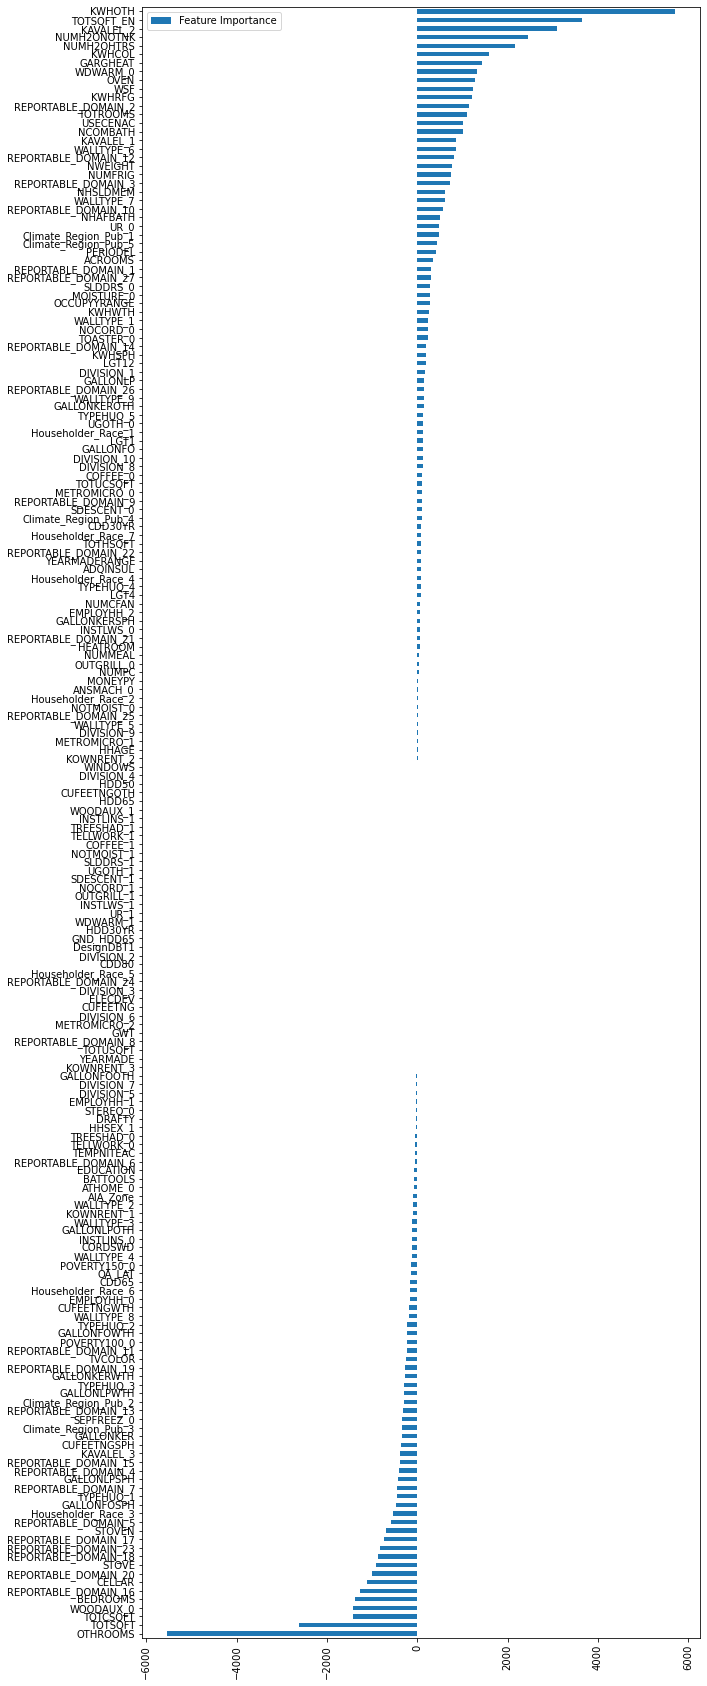

In [8]:
lasso=Lasso(alpha=0.001)
lasso.fit(train,np.exp(y_train)-1)
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=all_data.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(10,30))
plt.xticks(rotation=90)
plt.show()

# 4 Modeling


## 4.1 Define a cross validation strategy

In [9]:
# for train
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=n_folds))
    return rmse

# for test
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))/y.mean()

## 4.2 Base Models

### 4.2.1 hyperparameters tuning on gridsearch method

Gridsearch method is used to find the optimum hyperparameters.

In [10]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(train.values, y_train)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

### 4.2.2 LASSO Regression

Use the sklearn's Robustscaler() method on pipeline to make it robust on outliers

#### 4.2.2.1 lasso tuning

In [11]:
# grid(Lasso()).grid_get({'alpha': [0.0001,0.0005,0.005,0.01,0.05,0.1],'max_iter':[10000]})

#### 4.2.2.2 lasso model

In [12]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0001, random_state=1))

### 4.2.3 Elastic Net Regression

#### 4.2.3.1 ENet tuning

In [13]:
# grid(ElasticNet()).grid_get({'alpha': [0.0001,0.0005,0.005,0.01,0.05,0.1],'l1_ratio': [0.01,0.1,0.5,0.9,1],'random_state':[1,2,3]})

#### 4.2.3.2 ENet model

In [14]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

### 4.2.4 Kernel Ridge Regression

#### 4.2.4.1 KRR tuning

In [15]:
# grid(KernelRidge()).grid_get({'alpha': [0.05,0.1,0.5,0.7,0.9,1,1.5],'kernel':['polynomial'],'degree': [1,2,3],'coef0':[1]})

#### 4.2.4.2 KRR model

In [16]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

### 4.2.5 Gradient Boosting Regression

With huber loss that makes it robust to outliers

#### 4.2.5.1 GBoost tuning

In [17]:
# grid(GradientBoostingRegressor()).grid_get({'n_estimators': [100,3000],'learning_rate': [0.05,0.5],'max_depth': [1,3],'max_features':['sqrt'],
#                              'min_samples_leaf': [15],'min_samples_split': [10],'loss': ['huber'],'random_state':[5]})
# grid(GradientBoostingRegressor()).grid_get({'n_estimators': [3000],'learning_rate': [0.5],'max_depth': [3],'max_features':['sqrt'],
#                              'min_samples_leaf': [5,20],'min_samples_split': [5,15],'loss': ['huber'],'random_state':[5,10]})

#### 4.2.5.2 GBoost model

In [18]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

### 4.2.6 XGBoost

In [19]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

### 4.2.7 LightGBM

In [20]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## 4.3 Base models scores

In [21]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1361 (0.0020)



In [22]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1370 (0.0023)



In [23]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.85429e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.22425e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.1926e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.20376e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.10548e-18): result may not be accurate.
  overwrite_a=False)


Kernel Ridge score: 0.0756 (0.0052)



In [24]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) #0.0864 (0.0141)

Gradient Boosting score: 0.0864 (0.0141)



In [25]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) #0.0512 (0.0059)

Xgboost score: 0.0512 (0.0059)



In [26]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std())) #0.0971 (0.0113)

LGBM score: 0.0971 (0.0113)



## 4.4 Stacking averaged models with a meta-model

In order to get a better result, stacking averaged model with a meta-model is used. 

In [27]:
# Stacking averaged Models Class
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [28]:
flatX = SimpleImputer().fit_transform(train.values)
flatY = SimpleImputer().fit_transform(y_train.reshape(-1,1)).ravel()
stack_model = stacking(mod=[ENet, model_xgb, KRR],meta_model=lasso)
score=rmse_cv(stack_model,flatX,flatY)
print(score.mean(),score.std())   # result: mean = 0.046

d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.99866e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.58607e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.78762e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.18387e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.19356e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-p

0.04659244080627119 0.0050464877633937325


## 4.5 Combining stacking feature with origial features

In [29]:
X_train_stack, X_test_stack = stack_model.get_oof(flatX,flatY,test.values)
X_train_add = np.hstack((flatX,X_train_stack))
X_test_add = np.hstack((test,X_test_stack))

d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.19158e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.71491e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.20376e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.22172e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.74413e-18): result may not be accurate.
  overwrite_a=False)


In [30]:
score=rmse_cv(stack_model,X_train_add,flatY)
print(score.mean(),score.std())  # result: mean = 0.044

d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.14696e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.73419e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.06692e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.88925e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.88853e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-p

0.04441236257646548 0.006063579222067281


# 5 Prediction

In [31]:
stack_model = stacking(mod=[ENet, model_xgb, KRR],meta_model=lasso)
stack_model.fit(flatX,flatY)
pred = np.exp(stack_model.predict(test.values))
print(pred)

d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.19158e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.71491e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.20376e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.22172e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-packages\sklearn\linear_model\_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.74413e-18): result may not be accurate.
  overwrite_a=False)
d:\Anaconda3\envs\python36Env\lib\site-p

[18423.13986322  9230.86495448  3224.02338152 ...  5807.89983443
  4131.50365862  9821.55893169]


## 5.1 Root mean squared error of prediction

In [32]:
rmsle(testdata['KWH'], pred)   # result: 0.052

0.05213643363759438

## 5.2 Submission

In [33]:
result=pd.DataFrame({'id':test_index, 'gt':testdata['KWH'],'prediction':pred})
result.to_csv("submission.csv",index=False)

# 6 Summary



## Project workflow 

1. Understanding the dataset and task; 
2. Selecting features;
3. Data cleaning and precessing; 
4. Training with several methods (Lasso, ENet, KRR, GBoost, XGBoost, LightGBM, Stacking models)
5. Prediction and evaluation. 

## Lesson learned

1. Key is to understand the meaning of data and select right features. 
2. Stacking different models can improve the accuracy.
3. XGBoost is accurate, but it's slow. 
4. Excel is useful in understanding the data intuitively. 
